In [1]:
import numpy as np
import h5py
from scipy.io import loadmat

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn import metrics
from distributed import Executor

import matplotlib.pyplot as plt
# from ipywidgets import interact
% matplotlib inline

/home/elyall/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [37]:
# filebase = '/Users/elyall/Dropbox/Data/7737_291_000'
# filebase = '/media/elyall/Data/7737/180118/7737_291_000' # single-depth
# ID = '7737'
filebase = '/media/elyall/Data/7142/170710/7142_220_002' # 4 depths
ID = '7142'
# filebase = '/media/elyall/Data2/9025/181021/9025_180_002' # 4 depths
# ID = '9025'
depth = [1,2,3,4];

expfile = filebase + '.exp'
# fn = [filebase + '.rois']
fn = [filebase + "_depth%01d" % d + '.rois' for d in depth]
print(expfile)
print(fn)

numX = 15      # number of neurons to test
n_iter = 2    # number of replicates for N samples
n_splits = 10  # cross-validation
max_iter = 100 # regression convergence

/media/elyall/Data/7142/170710/7142_220_002.exp
['/media/elyall/Data/7142/170710/7142_220_002_depth1.rois', '/media/elyall/Data/7142/170710/7142_220_002_depth2.rois', '/media/elyall/Data/7142/170710/7142_220_002_depth3.rois', '/media/elyall/Data/7142/170710/7142_220_002_depth4.rois']


In [73]:
# Load stim info
myfile = h5py.File(expfile,'r')
StimID = myfile['/TrialInfo/StimID'].value[:].astype('int')
StimLog = myfile['/Experiment/stim/stim'].value[:].transpose().astype('int64')
TrialIndex = myfile['TrialIndex'].value[:].astype('int') - 1
myfile.close()

# Load neural data
temp = []
for f in fn:
    myfile = h5py.File(f,'r')
    numNeurons = len(myfile['ROIdata/rois/stimMean'])
    numTrials = len(myfile['ROIdata/DataInfo/StimID'][0])
    data = np.zeros([numTrials,numNeurons])
    for n in np.arange(numNeurons):
        data[:,n] = myfile[myfile['ROIdata/rois/stimMean'][n][0]].value
    myfile.close()
    temp.append(data)
data = np.concatenate(temp[:],axis=1)

# keep only desired trials
StimID = np.squeeze(StimID[TrialIndex])
data = np.squeeze(data[TrialIndex,:])
StimLog = StimLog[StimID,:]
# data = np.random.random([np.size(TrialIndex),100]) # fake data

numTrials, numNeurons = np.shape(data)
# number_of_neurons = np.logspace(0,2.6,13).round().astype('int') # list of number of neurons to sample
# number_of_neurons = np.append(number_of_neurons,numNeurons)
number_of_neurons = np.logspace(0,np.log10(numNeurons),numX).round().astype('int') # list of number of neurons to sample
number_of_neurons = np.unique(number_of_neurons)
numX = len(number_of_neurons)
print('%01d trials with %01d neurons while randomly sampling the following neurons:' % (numTrials,numNeurons), number_of_neurons)

655 trials with 795 neurons while randomly sampling the following neurons: [  1   2   3   4   7  11  17  28  45  73 118 190 306 493 795]


In [68]:
# Convert StimLog to vector
a = [1,2,4,8,16]
StimLog = StimLog.astype('int')
for i in np.arange(StimLog.shape[1]):
#     StimLog[:, i] *= i+1
    StimLog[:, i] *= a[i]
StimLog = StimLog.sum(axis=1)

In [58]:
def classify(number_of_neurons):
    
    # initialize outputs
    pred = np.zeros([numTrials,n_iter])
#     pred = np.zeros([numTrials,5,n_iter])
    perc_correct = np.zeros([n_iter])
    
    for ind in np.arange(n_iter):

        # pull out sample of neurons
        my_sample = np.random.choice(range(numNeurons), number_of_neurons)
        current = data[:,my_sample]

        # fit classifier to random sample (using KFold cross-validation)
        skf = StratifiedShuffleSplit(n_splits=n_splits)
        for train_index, test_index in skf.split(current, StimID):
            X_train, X_test = current[train_index,:], current[test_index,:]
            #y_train, y_test = StimID[train_index], StimID[test_index]
            y_train, y_test = StimLog[train_index], StimLog[test_index]
            
            mdl = linear_model.LogisticRegression(multi_class='multinomial',max_iter=max_iter,solver='sag')
            #mdl = RandomForestClassifier(n_estimators=100, n_jobs=-1)
            
            #mdl.fit(X_train, np.ravel(y_train))
            mdl.fit(X_train, y_train)

            pred[test_index,ind] = mdl.predict(X_test)
#             pred[test_index,:,ind] = mdl.predict(X_test)

        perc_correct[ind] = metrics.accuracy_score(StimID, pred[:,ind])
#         perc_correct[ind] = metrics.accuracy_score(StimLog, pred[:,:,ind])

    return(perc_correct, pred)


# Compute classifier

# # single thread
# pred = np.zeros([numTrials,n_iter,numX])
# # pred = np.zeros([numTrials,5,n_iter,numX])
# perc_correct = np.zeros([n_iter,numX])
# for n, N in enumerate(number_of_neurons):
#     perc_correct[:,n], pred[:,:,n] = classify(N)
# #     perc_correct[:,n], pred[:,:,:,n] = classify(N)

# mult-threaded
e = Executor()
Futures = e.map(classify, number_of_neurons)
out = e.gather(Futures)
e.close()
pred = np.zeros([numTrials,n_iter,numX])
# pred = np.zeros([numTrials,5,n_iter,numX])
perc_correct = np.zeros([n_iter,numX])
for n, N in enumerate(number_of_neurons):
    perc_correct[:,n] = out[n][0]
    pred[:,:,n] = out[n][1]
#     pred[:,:,:,n] = out[n][1]

/home/elyall/anaconda3/lib/python3.6/site-packages/distributed/client.py:3482: UserWarning: Executor has been renamed to Client
  warnings.warn("Executor has been renamed to Client")
/home/elyall/anaconda3/lib/python3.6/site-packages/distributed/bokeh/core.py:56: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


ValueError: bad input shape (589, 5)

In [ ]:
# %%time
# # DOESN'T WORK BECAUSE DASK DISTRIBUTED CACHES THE RESULT OF THE FIRST ITERATION TO ALL FUTURE CALLS WITH THE SAME INPUT

# def classify2(number_of_neurons):
    
#     # pull out sample of neurons
#     my_sample = np.random.choice(range(numNeurons), number_of_neurons)
#     current = data[:,my_sample]

#     # fit classifier to random sample (using KFold cross-validation)
#     pred = np.zeros([numTrials])
#     skf = StratifiedShuffleSplit(n_splits=n_splits)
#     for train_index, test_index in skf.split(current, StimID):
#         X_train, X_test = current[train_index,:], current[test_index,:]
#         y_train, y_test = StimID[train_index], StimID[test_index]

# #         mdl = linear_model.LogisticRegression(max_iter=max_iter,solver='sag',multi_class='multinomial')
#         mdl = RandomForestClassifier(n_estimators=100, n_jobs=-1)

#         mdl.fit(X_train, np.ravel(y_train))

#         pred[test_index] = mdl.predict(X_test)

#     perc_correct = metrics.accuracy_score(StimID, pred)
#     # confusion_matrix = metrics.confusion_matrix(StimID, pred[:,ind,n])

#     return(perc_correct, pred)

# # mult-threaded
# X = np.repeat(number_of_neurons,n_iter)
# e = Executor()
# Futures = e.map(classify2, X)
# out = e.gather(Futures)
# e.close()
# # reshape output
# pred = np.zeros([numTrials,n_iter,numX])
# perc_correct = np.zeros([n_iter,numX])
# _, Nind = np.unique(X, return_inverse=True)
# Iind = np.mod(np.arange(len(X)),n_iter)
# for n, x, y in zip(np.arange(len(X)), Nind, Iind):
#     perc_correct[y,x] = out[n][0]
#     pred[:,y,x] = out[n][1]

In [59]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression

classifiers = {
    'Logistic Regression' : LogisticRegression(multi_class='multinomial',max_iter=max_iter,solver='sag'),
#     'One vs Rest' : OneVsRestClassifier(SVC(kernel='linear')),
#     'Decision Tree' : DecisionTreeClassifier(),
#     'Extra Tree' : ExtraTreeClassifier(),
#     'Extra Trees' : ExtraTreesClassifier(),
#     'K Neighbors' : KNeighborsClassifier(),
#     'Multi-layer Perceptron' : MLPClassifier(),
# #     'Radius Neighbors': RadiusNeighborsClassifier(radius=10.0),
# #     'Ridge (CV)': RidgeClassifierCV(), # has formatting issue (pred is Nx1 not Nx5)
    'Random Forest': RandomForestClassifier(),
}
n_classifiers = len(classifiers)
print('%d classifier(s)' % n_classifiers)

2 classifier(s)


In [70]:
def classify3(number_of_neurons):
    
    # initialize outputs
    pred = np.zeros([numTrials,n_classifiers,n_iter])
#     pred = np.zeros([numTrials,5,n_classifiers,n_iter])
    perc_correct = np.zeros([n_classifiers,n_iter])
    
    for ind in np.arange(n_iter):

        # pull out sample of neurons
        my_sample = np.random.choice(range(numNeurons), number_of_neurons)
        current = data[:,my_sample]

        # perform K-fold cross validation
        skf = StratifiedShuffleSplit(n_splits=n_splits)
        for train_index, test_index in skf.split(current, StimID):
            X_train, X_test = current[train_index,:], current[test_index,:]
            y_train, y_test = StimLog[train_index], StimLog[test_index]
#             y_train, y_test = StimLog[train_index,:], StimLog[test_index,:]
                        
            # fit each classifer
            for index, (name, classifier) in enumerate(classifiers.items()):
                classifier.fit(X_train, y_train)
                pred[test_index,index,ind] = classifier.predict(X_test)
#                 pred[test_index,:,index,ind] = classifier.predict(X_test)
                perc_correct[index,ind] = metrics.accuracy_score(y_test, pred[test_index,index,ind])
#                 perc_correct[index,ind] = metrics.accuracy_score(y_test, pred[test_index,:,index,ind])

    return(perc_correct, pred)


# Compute classifier

# # single thread
# pred = np.zeros([numTrials,5,n_classifiers,n_iter,numX])
# perc_correct = np.zeros([n_classifiers,n_iter,numX])
# for n, N in enumerate(number_of_neurons):
#     perc_correct[:,:,n], pred[:,:,:,:,n] = classify3(N)

# mult-threaded
e = Executor()
Futures = e.map(classify3, number_of_neurons)
out = e.gather(Futures)
e.close()
pred = np.zeros([numTrials,n_classifiers,n_iter,numX])
# pred = np.zeros([numTrials,5,n_classifiers,n_iter,numX])
perc_correct = np.zeros([n_classifiers,n_iter,numX])
for n, N in enumerate(number_of_neurons):
    perc_correct[:,:,n] = out[n][0]
    pred[:,:,:,n] = out[n][1]
#     pred[:,:,:,:,n] = out[n][1]

/home/elyall/anaconda3/lib/python3.6/site-packages/distributed/client.py:3482: UserWarning: Executor has been renamed to Client
  warnings.warn("Executor has been renamed to Client")
/home/elyall/anaconda3/lib/python3.6/site-packages/distributed/bokeh/core.py:56: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [11]:
# Save output
h5f = h5py.File(filebase + '.h5', 'w')
h5f.create_dataset('/perc_correct', data=perc_correct)
h5f.create_dataset('/pred', data=pred)
h5f.create_dataset('/number_of_neurons', data=number_of_neurons)
h5f.close()

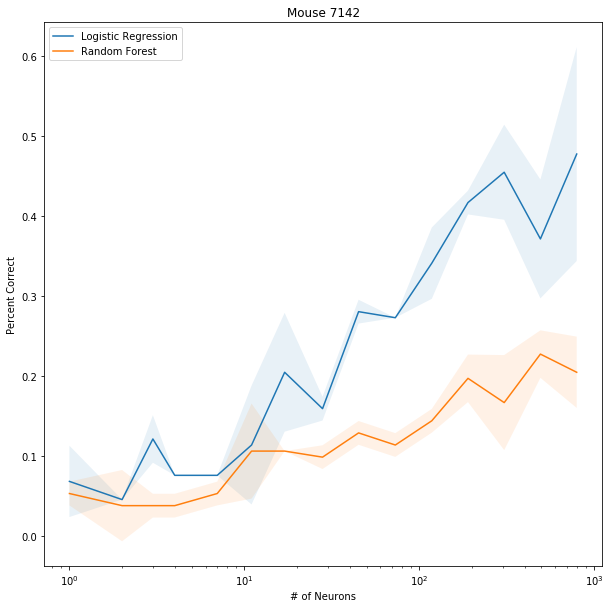

In [66]:
# Plot output
X = number_of_neurons
Y = np.mean(perc_correct,axis=1)
E = 1.96*np.std(perc_correct,axis=1)

fig, ax = plt.subplots(1,1,figsize=(10,10))
for ind, (y,e,l) in enumerate(zip(Y,E,list(classifiers.keys()))):
    ax.plot(X, y, label=l)
    ax.fill_between(X, y-e, y+e, alpha=0.1, antialiased=True)
#     ax.errorbar(X, y, yerr=e, label=l)
ax.set_ylabel('Percent Correct')
ax.set_xlabel('# of Neurons')
ax.set_xscale('log')
ax.set_title('Mouse ' + ID)
ax.legend(loc='upper left')

# # Save plot
# fig.savefig(ID + '_percCorrect.pdf')
# fig.savefig(ID + '_percCorrect.eps')

In [ ]:
# # Display single confusion matrix
# x = np.ceil(np.sqrt(numX)).astype('int')
# y = np.ceil(numX/x).astype('int')
# fig, axs = plt.subplots(y,x,sharex=True,sharey=True,figsize=(10,10))
# for ax, n in zip(axs.flat,range(numX)):
#     confusion_matrix = metrics.confusion_matrix(np.repeat(StimID,n_iter), np.ravel(pred2[:,:,n]))
#     ax.imshow(confusion_matrix)
#     ax.set_title('%d' % number_of_neurons[n])
# fig.text(0.5, 0.04, 'Predicted Label', ha='center')
# fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical')
    
# fig.savefig(ID + '_RF_CM.png')

In [ ]:
# # Display lots of confusion matrices
# fig, ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,10))
# confusion_matrix = metrics.confusion_matrix(np.repeat(StimID,n_iter), np.ravel(pred2[:,:,-1]))
# ax.imshow(confusion_matrix)
# ax.set_title(ID + ' RF (neurons=%d)' % number_of_neurons[-1])
# ax.set_ylabel('True label')
# ax.set_xlabel('Predicted label')

# fig.savefig(ID + '_RF_CM_%d.png' % number_of_neurons[-1])